In [54]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
SSC_struct_rank_fil = "dat/bias/asd.ssc.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_zmatch_graph_size, ssc_zmatch_stats, ssc_graphs = CircuitTrimming(g2, g)

In [105]:
SSC_struct_rank_fil = "dat/bias/ssc.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_elevel_graph_size, ssc_elevel_stats, ssc_graphs = CircuitTrimming(g2, g)

In [96]:
SSC_struct_rank_fil = "dat/bias/asd.tada.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_zmatch_graph_size, tada_zmatch_stats, tada_graphs = CircuitTrimming(g2, g)

In [106]:
SSC_struct_rank_fil = "dat/bias/tada.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_elevel_graph_size, tada_elevel_stats, tada_graphs = CircuitTrimming(g2, g)

In [99]:
SSC_struct_rank_fil = "dat/bias/asd.sib.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_zmatch_graph_size, sib_zmatch_stats, sib_graphs = CircuitTrimming(g2, g)

In [101]:
SSC_struct_rank_fil = "dat/bias/sib.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_elevel_graph_size, sib_elevel_stats, sib_graphs = CircuitTrimming(g2, g)

In [121]:
rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=rand_strs)
g2 = g.subgraph(top_nodes)
rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)

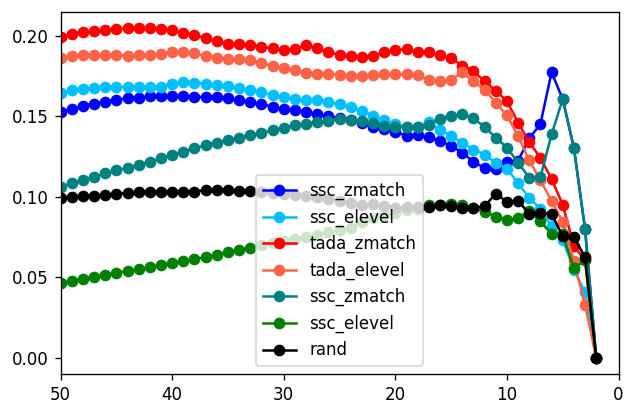

In [122]:
fig, ax = plt.subplots()
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="ssc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="ssc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="tada_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="tada_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()

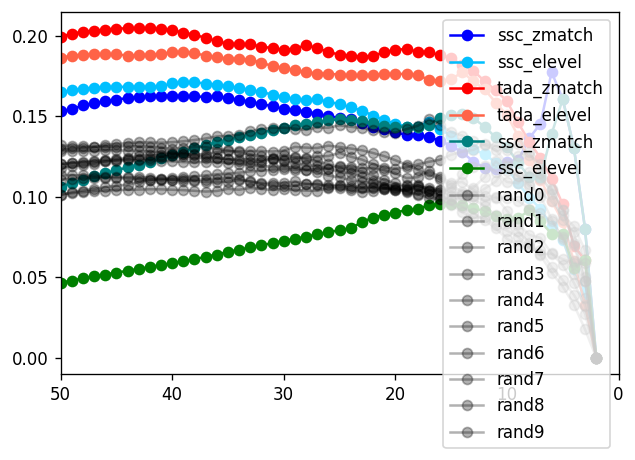

In [124]:
fig, ax = plt.subplots()
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="ssc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="ssc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="tada_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="tada_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
for i in range(10):
    rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
    g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
    top_nodes = g.vs.select(label_in=rand_strs)
    g2 = g.subgraph(top_nodes)
    rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)
    ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand%d"%i, alpha=0.3)
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()